## Analyzing full sweep: sub5, n=5

In [1]:
import os
import pickle

import numpy as np
import matplotlib.pyplot as plt
import gvar as gv
import scipy.sparse as sp
import scipy.sparse.linalg as sla
import lsqfit # WARNING: lsqfit 12.0 appears to be broken. `python3 -m pip install lsqfit==11.8`

from z2_sim.src.NumericsPython.Analysis.fourieranalysis import fourier_ana
from z2_sim.src.QuantumCircuits.Cirq_Code import io

In [2]:
%load_ext autoreload
%autoreload 2

### The data management is yucky.

But you already know that by now. See `noise_analysis_sub3`

In [24]:
noiseless_directory = "./results/noiseless"
flag = 'obc'
ns = [5]

# Load the noiseless data into a single dictionary that can be passed to `fourier_ana`
noiseless_data = {}
noiseless_tag = "control"


dts = [0.25]


for n in ns:
    noiseless_subdirectory = os.path.join(noiseless_directory, f"{n}/")
    noiseless_fname = f'noiseless_parameter_sweep_{noiseless_tag}_results_n{n}_{flag}.npy'
    arr = np.load(os.path.join(noiseless_subdirectory, noiseless_fname))[:,:,:50,:,:]
    noiseless_data[(flag, n)] = arr

# Submission card
dt = 0.25
j_sweep = np.asarray([0.714285, 0.625, .555556])
zeta_sweep = [0, 150000, 300000, 450000, 600000, 750000]
eps_sweep = [0, 0.0005, 0.001, 0.0015, 0.002, 0.0025, 0.003]
n_trajectories = 1000
tstart = 1
tstop = 51
nprocs = 1

        
        
# assert statements never hurt anyone
j_sweep_control = np.load( os.path.join(noiseless_directory, io.make_physical_params_sweep_fname(noiseless_tag, 'jcoup')))
assert np.allclose(j_sweep, j_sweep_control, atol=1e-5, rtol=1e-4)

noisy_directory = './results/noisy'
beta_sweep = 1 / j_sweep
assert np.allclose(beta_sweep, [1.4, 1.6, 1.8])
beta_sweep = [1.4, 1.6, 1.8]
beta_keys = np.round(beta_sweep, decimals=6)


# # Load the data into separate dictionaries that can be passed to `fourier_ana`
# # This way, any element of this data sequence can be treated on equal footing 
# # with a noiseless data array.
noisy_data_grid = [[{} for _ in range(len(eps_sweep))] for _ in range(len(zeta_sweep))]

for n in ns:
    noisy_subdirectory = os.path.join(noisy_directory, f"{n}/")
    collector = io.CondorCollector(
        path=noisy_subdirectory,
        nprocs=nprocs,
        n=n,
        j_sweep=j_sweep,
        dt_sweep=[dt],
        trotter_intervals=[(tstart, tstop)],
        zeta_sweep=zeta_sweep,
        eps_sweep=eps_sweep, # don't look for eps=0
        r=n_trajectories,
    )

    #!! epsilon dependence stored in the 4th index
    #!! shot dependence stored in the 0th index
    data_arr = collector.collect_htcondor_outputs()
    for i in range(len(zeta_sweep)):
        for j in range(len(eps_sweep)):
            # (nprocs, len(j_sweep), len(dt_sweep), len(zeta_sweep), len(eps_sweep), trotter_steps, n, n)
            noisy_data_grid[i][j][('obc', n)] = data_arr[:,:,:,i,j,:,:,:].mean(axis=0)


In [27]:
import pickle
with open(f'./final/noisy/{n}/noisy_n{n}_raw.pickle', 'w') as f:
    pickle.dump(noisy_data_grid, f)

TypeError: an integer is required (got type _io.TextIOWrapper)

#### Verify that noisy results are seeded differently!

The fact that the plot below has many lines means that each noisy simulation was different. This was a concern of mine that seeds might get duplicated during the condor submission process.

### Perform the fourier analysis and mass analysis on each dataset

Noiseless datset followed by noisy dataset at each noise parameter.

In [5]:
bc_flags = ['obc']
noiseless_fourier = fourier_ana(
    results=noiseless_data, 
    bc_flags=bc_flags, 
    grid_sizes=ns, 
    dts=dts, 
    betas=beta_sweep, 
    n_trotter=50, 
    samp_rate = 2048, 
    nboot = 200)

noisy_fourier_grid = [[None for _ in range(len(eps_sweep))] for _ in range(len(zeta_sweep))]
for i in range(len(zeta_sweep)):
    for j in range(len(eps_sweep)):
        noisy_data = noisy_data_grid[i][j]
        noisy_fourier = fourier_ana(
            results=noisy_data, 
            bc_flags=bc_flags, 
            grid_sizes=ns, 
            dts=dts, 
            betas=beta_sweep, 
            n_trotter=50, 
            samp_rate = 2048, 
            nboot = 200
        )
        noisy_fourier_grid[i][j] = noisy_fourier


In [6]:
noisy_data_grid[-1][2][('obc', n)][2, 0,:,1,1].real

array([-0.0030549 , -0.01394077, -0.0086096 ,  0.01030588,  0.04600289,
        0.09242173,  0.09903587,  0.066152  ,  0.06352582,  0.04645596,
       -0.00665176, -0.0399244 , -0.05099275, -0.05211119, -0.02947793,
       -0.00555723,  0.01335991,  0.0276996 ,  0.0317035 ,  0.02929134,
        0.02582815,  0.02149062,  0.01948905,  0.01832953,  0.01876569,
        0.01775046,  0.01910602,  0.01938729,  0.02003274,  0.01994301,
        0.01812937,  0.01572723,  0.01433707,  0.01395098,  0.01392975,
        0.01386472,  0.01375551,  0.01211799,  0.01208535,  0.01107388,
        0.01046222,  0.01093338,  0.01078826,  0.01068748,  0.00995227,
        0.01018354,  0.00999312,  0.01003668,  0.01009651,  0.00964239])

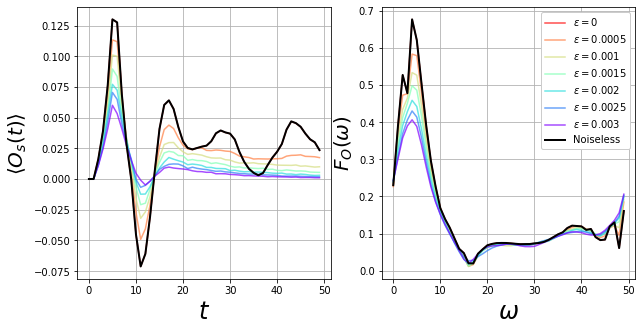

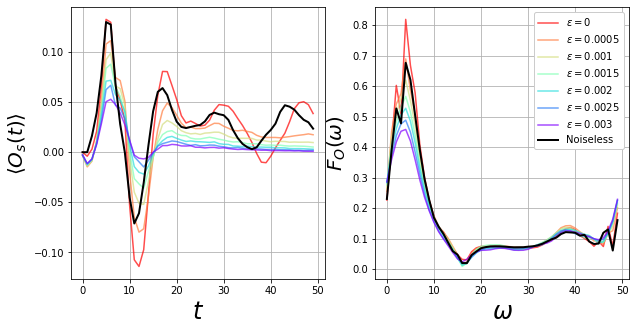

In [7]:
import matplotlib.cm as cm

colors = list(reversed([x for x in cm.rainbow(np.linspace(0, 1, len(eps_sweep) )) ]))
k = 2
beta = beta_sweep[k]
trotter_steps = 50
for zeta_idx in [0, -1]:
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    # Plot time series
    # axes: [beta, dt, trotter_step, n, n]
    # slice for dt=0.25, and keep only beta in [1.4, 1.6, 1.8]
    for i, eps in enumerate(eps_sweep):
        y = noisy_data_grid[zeta_idx][i][('obc', n)][k, 0,:,1,1].real
        axes[0].plot(range(trotter_steps), y, label=f'{eps}', c=colors[i], alpha=0.7)    
    # Plot spectrum
    for i, eps in enumerate(eps_sweep):
        y = noisy_fourier_grid[zeta_idx][i][0][('obc', n, 0.25, beta)]
        axes[1].plot(range(trotter_steps), y, label=r"$\epsilon=$" + f'{eps}', c=colors[i], alpha=0.7)

    axes[0].plot(noiseless_data[('obc', n)][k, 0,:,1,1].real, label="Noiseless", c='k', lw=2)
    axes[1].plot(noiseless_fourier[0][('obc', n, 0.25, beta)], label="Noiseless", c='k', lw=2)

    axes[0].set_ylabel(r"$\langle O_s(t) \rangle$", size=20)
    axes[0].set_xlabel(r"$t$", size=24)
    axes[1].set_xlabel(r"$\omega$", size=24)
    axes[1].set_ylabel(r"$F_O(\omega) $", size=20)

    axes[1].legend(bbox_to_anchor=(1.0, 1), framealpha=1)
    for ax in axes:
        ax.grid()
# fig.savefig("../figures/sample_epsilon_timeseries.pdf")
    

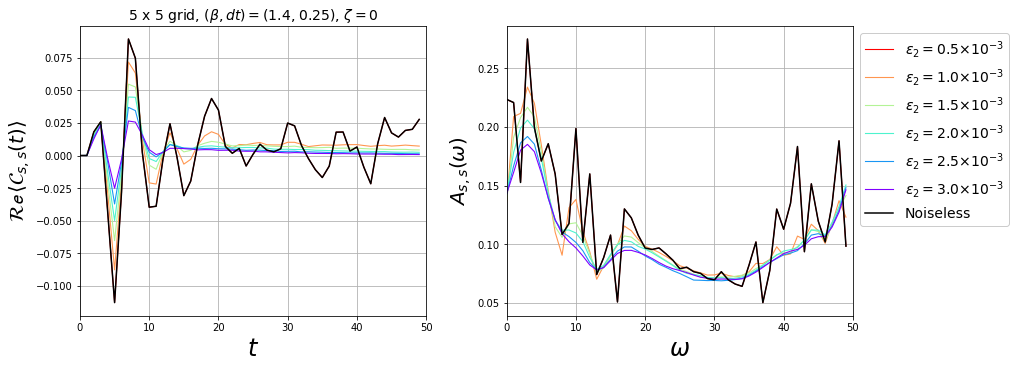

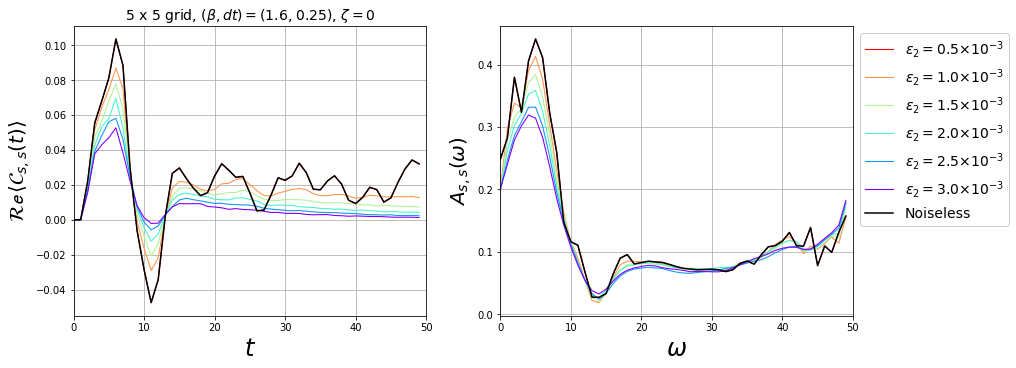

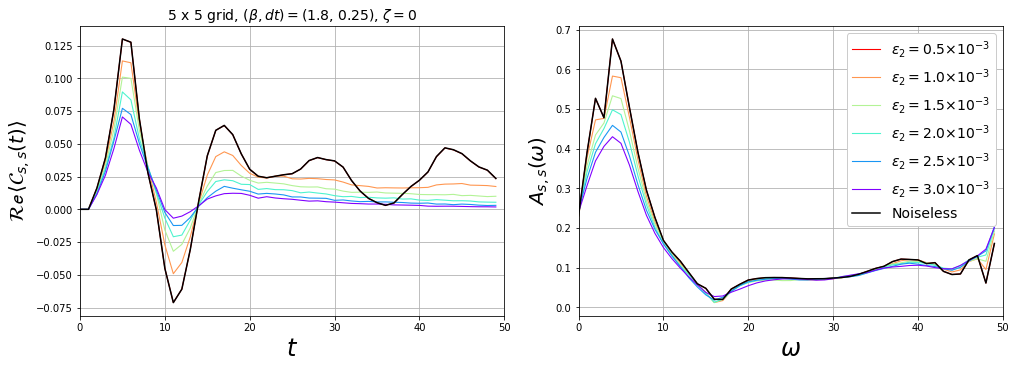

In [8]:
import matplotlib.cm as cm

colors = list(reversed([x for x in cm.rainbow(np.linspace(0, 1, len(eps_sweep) -1 )) ]))
for k in range(3):
#     k = 0
    beta = beta_sweep[k]
    trotter_steps = 50
    zeta_idx = 0


    fig, axes = plt.subplots(1, 2, figsize=(14, 5), constrained_layout=True)
    # Plot time series
    # axes: [beta, dt, trotter_step, n, n]
    # slice for dt=0.25, and keep only beta in [1.4, 1.6, 1.8]
    for i, eps in enumerate(eps_sweep[1:]):
        y = noisy_data_grid[zeta_idx][i][('obc', n)][k, 0,:,1,1].real
        lab = r"$\epsilon_2=$" + f"{eps * 10**3}" + r"$\times 10^{-3}$"
        axes[0].plot(range(trotter_steps), y, label=lab, c=colors[i], alpha=1, lw=1.1)    
    # Plot spectrum
    for i, eps in enumerate(eps_sweep[1:]):
        y = noisy_fourier_grid[zeta_idx][i][0][('obc', n, 0.25, beta)]
        lab = r"$\epsilon_2=$" + f"{eps * 10**3}" + r"$\times 10^{-3}$"
        axes[1].plot(range(trotter_steps), y, label=lab, c=colors[i], alpha=1, lw=1.1)

    # OVERLAY NOISELESS
    axes[0].plot(noiseless_data[('obc', n)][k, 0,:,1,1].real, label="Noiseless", c='k', lw=1.5)
    axes[1].plot(noiseless_fourier[0][('obc', n, 0.25, beta)], label="Noiseless", c='k', lw=1.5)

    axes[0].set_title(f"{n} x {n} grid, " + r"$(\beta, dt)= $" + f"({beta}, 0.25), " + r"$\zeta=0$", size=14)

    axes[0].set_ylabel(r"$\mathcal{Re}\,\langle \mathcal{C}_{s,s}(t) \rangle$", size=20)
    axes[0].set_xlabel(r"$t$", size=24)
    axes[1].set_xlabel(r"$\omega$", size=24)
    axes[1].set_ylabel(r"$A_{s,s}(\omega) $", size=20)

    axes[1].legend(bbox_to_anchor=(1.0, 1), framealpha=1, prop={'size': 14})
    for ax in axes:
        ax.grid()
        ax.set_xlim(0, 50)
# fig.savefig(f"../figures/sample_n{n}_zeta0_eps_timeseries.pdf")

## DEMO PLOTS


### $\zeta=0$, $\epsilon_2$ sweep

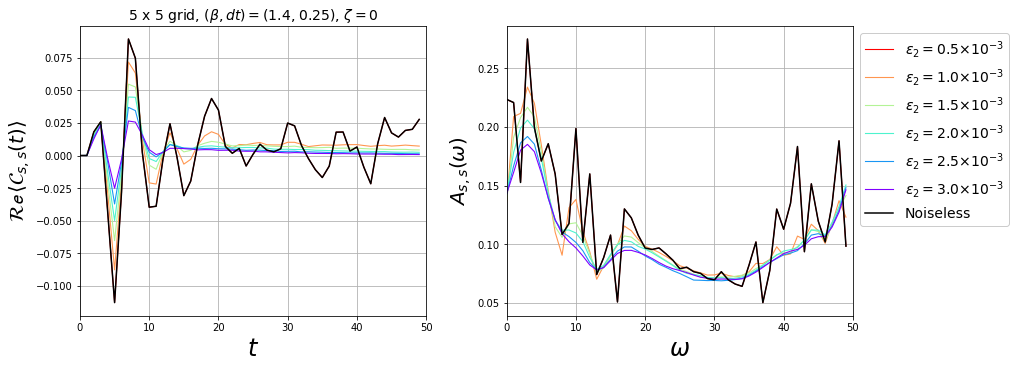

In [9]:
import matplotlib.cm as cm

colors = list(reversed([x for x in cm.rainbow(np.linspace(0, 1, len(eps_sweep) -1 )) ]))
k = 0
beta = beta_sweep[k]
trotter_steps = 50
zeta_idx = 0


fig, axes = plt.subplots(1, 2, figsize=(14, 5), constrained_layout=True)
# Plot time series
# axes: [beta, dt, trotter_step, n, n]
# slice for dt=0.25, and keep only beta in [1.4, 1.6, 1.8]
for i, eps in enumerate(eps_sweep[1:]):
    y = noisy_data_grid[zeta_idx][i][('obc', n)][k, 0,:,1,1].real
    lab = r"$\epsilon_2=$" + f"{eps * 10**3}" + r"$\times 10^{-3}$"
    axes[0].plot(range(trotter_steps), y, label=lab, c=colors[i], alpha=1, lw=1.1)    
# Plot spectrum
for i, eps in enumerate(eps_sweep[1:]):
    y = noisy_fourier_grid[zeta_idx][i][0][('obc', n, 0.25, beta)]
    lab = r"$\epsilon_2=$" + f"{eps * 10**3}" + r"$\times 10^{-3}$"
    axes[1].plot(range(trotter_steps), y, label=lab, c=colors[i], alpha=1, lw=1.1)

# OVERLAY NOISELESS
axes[0].plot(noiseless_data[('obc', n)][k, 0,:,1,1].real, label="Noiseless", c='k', lw=1.5)
axes[1].plot(noiseless_fourier[0][('obc', n, 0.25, beta)], label="Noiseless", c='k', lw=1.5)

axes[0].set_title(f"{n} x {n} grid, " + r"$(\beta, dt)= $" + f"({beta}, 0.25), " + r"$\zeta=0$", size=14)

axes[0].set_ylabel(r"$\mathcal{Re}\,\langle \mathcal{C}_{s,s}(t) \rangle$", size=20)
axes[0].set_xlabel(r"$t$", size=24)
axes[1].set_xlabel(r"$\omega$", size=24)
axes[1].set_ylabel(r"$A_{s,s}(\omega) $", size=20)

axes[1].legend(bbox_to_anchor=(1.0, 1), framealpha=1, prop={'size': 14})
for ax in axes:
    ax.grid()
    ax.set_xlim(0, 50)
fig.savefig(f"../figures/sample_n{n}_zeta0_eps_timeseries.pdf")

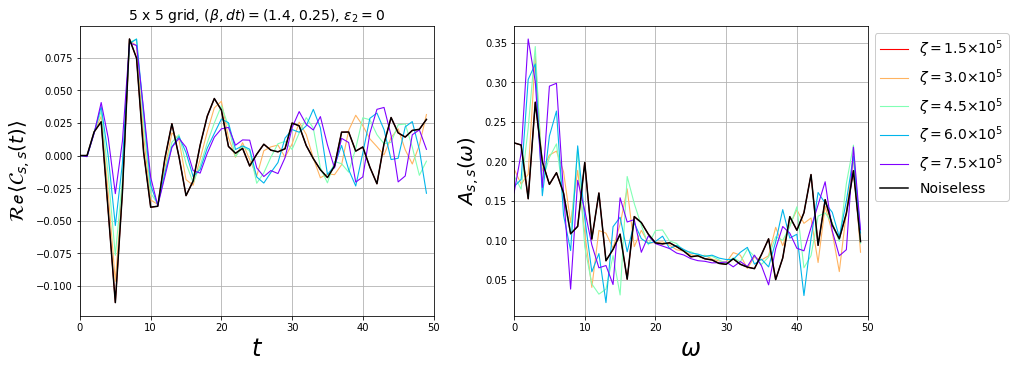

In [10]:
colors = list(reversed([x for x in cm.rainbow(np.linspace(0, 1, len(zeta_sweep)-1)) ]))
k = 0
beta = beta_sweep[k]
trotter_steps = 50
eps_idx = 0


fig, axes = plt.subplots(1, 2, figsize=(14, 5), constrained_layout=True)
# Plot time series
# axes: [beta, dt, trotter_step, n, n]
# slice for dt=0.25, and keep only beta in [1.4, 1.6, 1.8]
for i, zeta in enumerate(zeta_sweep[1:]):
    y = noisy_data_grid[i][eps_idx][('obc', n)][k, 0,:,1,1].real
    lab = r"$\zeta=$" + f"{zeta / 10**5}" + r"$\times 10^5$"
    axes[0].plot(range(trotter_steps), y, label=lab, c=colors[i], alpha=1, lw=1.1)    
# Plot spectrum
for i, zeta in enumerate(zeta_sweep[1:]):
    y = noisy_fourier_grid[i][eps_idx][0][('obc', n, 0.25, beta)]
    lab = r"$\zeta=$" + f"{zeta / 10**5}" + r"$\times 10^5$"
    axes[1].plot(range(trotter_steps), y, label=lab, c=colors[i], alpha=1, lw=1.1)

# OVERLAY NOISELESS
axes[0].plot(noiseless_data[('obc', n)][k, 0,:,1,1].real, label="Noiseless", c='k', lw=1.5)
axes[1].plot(noiseless_fourier[0][('obc', n, 0.25, beta)], label="Noiseless", c='k', lw=1.5)

axes[0].set_title(f"{n} x {n} grid, " + r"$(\beta, dt)= $" + f"({beta}, 0.25), " + r"$\epsilon_2=0$", size=14)

axes[0].set_ylabel(r"$\mathcal{Re}\,\langle \mathcal{C}_{s,s}(t) \rangle$", size=20)
axes[0].set_xlabel(r"$t$", size=24)
axes[1].set_xlabel(r"$\omega$", size=24)
axes[1].set_ylabel(r"$A_{s,s}(\omega) $", size=20)

axes[1].legend(bbox_to_anchor=(1.0, 1), framealpha=1, prop={'size': 14})
for ax in axes:
    ax.grid()
    ax.set_xlim(0, 50)
    
fig.savefig(f"../figures/sample_n{n}_zeta_eps0_timeseries.pdf")

### Shared plot!


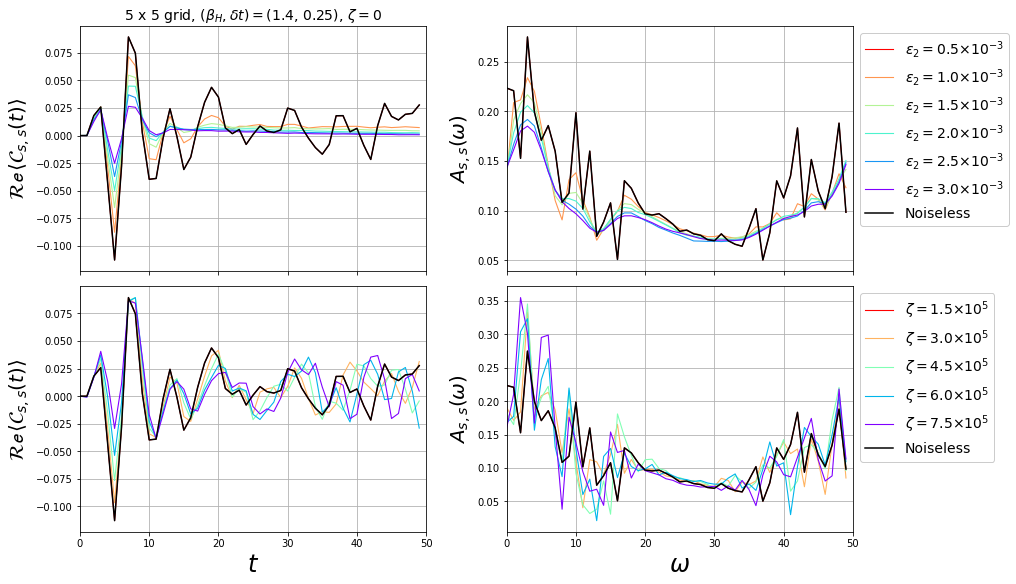

In [11]:

colors = list(reversed([x for x in cm.rainbow(np.linspace(0, 1, len(eps_sweep) -1 )) ]))
k = 0
beta = beta_sweep[k]
trotter_steps = 50
zeta_idx = 0


fig, axes = plt.subplots(2, 2, figsize=(14, 8), constrained_layout=True, sharex=True, sharey=False)
# Plot time series
# axes: [beta, dt, trotter_step, n, n]
# slice for dt=0.25, and keep only beta in [1.4, 1.6, 1.8]
for i, eps in enumerate(eps_sweep[1:]):
    y = noisy_data_grid[zeta_idx][i][('obc', n)][k, 0,:,1,1].real
    lab = r"$\epsilon_2=$" + f"{eps * 10**3}" + r"$\times 10^{-3}$"
    axes[0,0].plot(range(trotter_steps), y, label=lab, c=colors[i], alpha=1, lw=1.1)    
# Plot spectrum
for i, eps in enumerate(eps_sweep[1:]):
    y = noisy_fourier_grid[zeta_idx][i][0][('obc', n, 0.25, beta)]
    lab = r"$\epsilon_2=$" + f"{eps * 10**3}" + r"$\times 10^{-3}$"
    axes[0,1].plot(range(trotter_steps), y, label=lab, c=colors[i], alpha=1, lw=1.1)

# OVERLAY NOISELESS
axes[0,0].plot(noiseless_data[('obc', n)][k, 0,:,1,1].real, label="Noiseless", c='k', lw=1.5)
axes[0,1].plot(noiseless_fourier[0][('obc', n, 0.25, beta)], label="Noiseless", c='k', lw=1.5)

axes[0,0].set_title(f"{n} x {n} grid, " + r"$(\beta_H, \delta t)= $" + f"({beta}, 0.25), " + r"$\zeta=0$", size=14)

axes[0,0].set_ylabel(r"$\mathcal{Re}\,\langle \mathcal{C}_{s,s}(t) \rangle$", size=20)
# axes[0,0].set_xlabel(r"$t$", size=24)
# axes[0,1].set_xlabel(r"$\omega$", size=24)
axes[0,1].set_ylabel(r"$A_{s,s}(\omega) $", size=20)

axes[0,1].legend(bbox_to_anchor=(1.0, 1), framealpha=1, prop={'size': 14})


colors = list(reversed([x for x in cm.rainbow(np.linspace(0, 1, len(zeta_sweep)-1)) ]))
# axes: [beta, dt, trotter_step, n, n]
# slice for dt=0.25, and keep only beta in [1.4, 1.6, 1.8]
for i, zeta in enumerate(zeta_sweep[1:]):
    y = noisy_data_grid[i][eps_idx][('obc', n)][k, 0,:,1,1].real
    lab = r"$\zeta=$" + f"{zeta / 10**5}" + r"$\times 10^5$"
    axes[1,0].plot(range(trotter_steps), y, label=lab, c=colors[i], alpha=1, lw=1.1)    
# Plot spectrum
for i, zeta in enumerate(zeta_sweep[1:]):
    y = noisy_fourier_grid[i][eps_idx][0][('obc', n, 0.25, beta)]
    lab = r"$\zeta=$" + f"{zeta / 10**5}" + r"$\times 10^5$"
    axes[1,1].plot(range(trotter_steps), y, label=lab, c=colors[i], alpha=1, lw=1.1)

# OVERLAY NOISELESS
axes[1,0].plot(noiseless_data[('obc', n)][k, 0,:,1,1].real, label="Noiseless", c='k', lw=1.5)
axes[1,1].plot(noiseless_fourier[0][('obc', n, 0.25, beta)], label="Noiseless", c='k', lw=1.5)

axes[1,0].set_ylabel(r"$\mathcal{Re}\,\langle \mathcal{C}_{s,s}(t) \rangle$", size=20)
axes[1,0].set_xlabel(r"$t$", size=24)
axes[1,1].set_xlabel(r"$\omega$", size=24)
axes[1,1].set_ylabel(r"$A_{s,s}(\omega) $", size=20)

axes[1,1].legend(bbox_to_anchor=(1.0, 1), framealpha=1, prop={'size': 14})
for ax in axes.flatten():
    ax.grid()
    ax.set_xlim(0, 50)
    
fig.savefig(f"../figures/sample_n{n}_zeta_eps_timeseries_combined.pdf")

## Bulk analysis

The primary analysis that we can apply en masse is to compare $\Delta E_{01}$ as a function of $dt$ across different noise strengths.

### Start by looking at mass versus dt

The following is less condensed but can maybe reveal trends in the noise behavior.

In [13]:
rel_err_grid = np.zeros((len(beta_sweep), len(zeta_sweep), len(eps_sweep)))
n = 5
dt = 0.25
for i, betakey in enumerate(beta_keys):

    # Plot noiseless energy vs dt
    ens = noiseless_fourier[1]
    noiseless_y = np.abs(np.array(gv.mean(ens[('obc', n, dt, betakey)])))

    for j, zeta in enumerate(zeta_sweep):
        for k, eps in enumerate(eps_sweep):
            ens_noisy = noisy_fourier_grid[j][k][1]

            # Compute and plot absolute error
            noisy_y = np.abs(np.array(gv.mean(ens_noisy[('obc', n, dt, betakey)])))
            noisy_yerr = gv.sdev(ens_noisy[('obc', n, dt, betakey)])

            # Plot relative error
            rel_err = (noisy_y - noiseless_y) / noiseless_y
            rel_err_grid[i,j,k] = rel_err
    rel_err_grid[i,0,0] = 0

In [14]:
rel_err_grid[0]

array([[ 0.        , -0.05990017, -0.03161398,  0.00499168,  0.16306156,
         0.14808652,  0.39600666],
       [-0.00166389, -0.04326123, -0.03660566, -0.01331115,  0.07154742,
         0.23627288,  0.1530782 ],
       [-0.00166389, -0.01996672, -0.00665557,  0.06156406,  0.0765391 ,
         0.02828619,  0.31946755],
       [-0.06655574, -0.03161398,  0.0515807 ,  0.12645591,  0.09816972,
         0.078203  ,  0.20965058],
       [-0.26788686,  0.11480865,  0.11813644,  0.1031614 ,  0.16971714,
         0.11314476,  0.23294509],
       [ 0.14975042,  0.17803661,  0.15973378,  0.17304493,  0.13311148,
         0.15806988,  0.08985025]])

In [15]:
rel_err_grid[1]

array([[ 0.        , -0.05083089, -0.08602151, -0.12707722, -0.16031281,
        -0.1827957 , -0.20527859],
       [-0.00391007, -0.02932551, -0.06549365, -0.09970674, -0.16324536,
        -0.18963832, -0.18475073],
       [-0.04301075, -0.04301075, -0.07722385, -0.12121212, -0.14076246,
        -0.18084066, -0.20723363],
       [-0.08699902, -0.05669599, -0.07722385, -0.13294233, -0.15249267,
        -0.16911046, -0.19843597],
       [-0.10459433, -0.07820137, -0.11339198, -0.14467253, -0.14760508,
        -0.17497556, -0.21603128],
       [-0.14467253, -0.11632454, -0.12609971, -0.14076246, -0.18377322,
        -0.1886608 , -0.23753666]])

In [16]:
rel_err_grid[2]

array([[ 0.        ,  0.09825871,  0.09079602,  0.08333333,  0.03233831,
         0.02985075,  0.0199005 ],
       [-0.00373134,  0.06343284,  0.0659204 ,  0.04850746,  0.03109453,
         0.02238806, -0.00995025],
       [-0.00497512,  0.02487562,  0.03358209,  0.02487562,  0.00373134,
        -0.01616915, -0.06840796],
       [-0.00497512,  0.00248756,  0.01616915,  0.01865672, -0.01119403,
        -0.02238806, -0.07587065],
       [-0.00497512, -0.00373134,  0.00373134, -0.01119403, -0.03358209,
        -0.05472637, -0.08457711],
       [-0.00497512, -0.00373134, -0.01243781, -0.02114428, -0.04353234,
        -0.08457711, -0.09079602]])

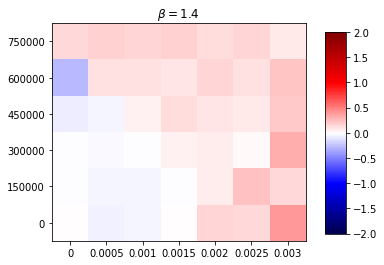

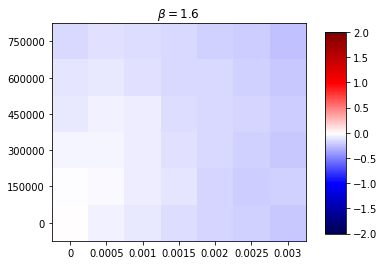

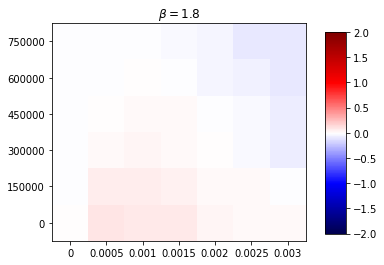

In [17]:
for i, beta in enumerate(beta_sweep):
    fig, ax = plt.subplots()
    im = ax.imshow(rel_err_grid[i], cmap="seismic", vmin=-2, vmax=2, origin='lower')
    ax.set_title(r"$\beta=$" + f"{beta}")
    ax.set_xticks(range(len(eps_sweep)))
    ax.set_xticklabels(eps_sweep)
    ax.set_yticks(range(len(zeta_sweep)))
    ax.set_yticklabels(zeta_sweep)
    
    cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
    fig.colorbar(im, cax=cbar_ax)

### Demo plot

In [18]:
import matplotlib.colors as colors
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

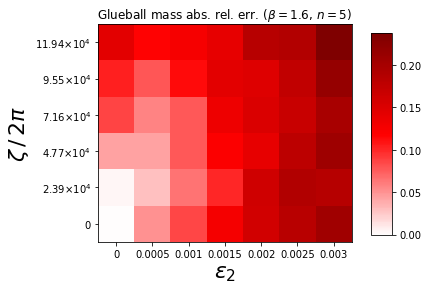

In [23]:
i = 1
beta = beta_sweep[i]
fig, ax = plt.subplots()
cmap = truncate_colormap(plt.get_cmap('seismic'), minval=0.5, maxval=1)
im = ax.imshow(abs(rel_err_grid[i]), cmap=cmap, vmin=0, origin='lower')
ax.set_xticks(range(len(eps_sweep)))
ax.set_xticklabels(eps_sweep)
ax.set_yticks(range(len(zeta_sweep)))
zeta_labs = ["0"] + [f"{zeta/(1e4 * np.pi * 2):3.2f}"+r"$\times 10^4$" for zeta in zeta_sweep[1:]]
ax.set_yticklabels(zeta_labs)

betastr = r"$\beta=$"+f"{beta}"
nstr = r"$n=$"+f"{n}"
ax.set_title(f"Glueball mass abs. rel. err. ({betastr}, {nstr})")
ax.set_xlabel(r"$\epsilon_2$", size=22)
ax.set_ylabel(r"$\zeta\,/\,2\pi$", size=22)

cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)
plt.savefig(f"../figures/glueball_err_demo_n{n}.pdf", bbox_inches='tight')